In [102]:
from IPython.display import HTML

In [1]:
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
from collections import defaultdict
from sklearn.neighbors import BallTree
import gc
%matplotlib inline

columns = ["pubId", "is_hourly", "seqId", "on_homepage", "canonicalUrl",
                   "firstScrape", "lang_iso", "lang_reliability", "title", "text"]

def read_article_df(file):
    articles_dt = file.read().split('\n')[:-1]
    pubId, canonicalUrl,firstScrape,title,text,lang_reliability = [],[],[],[],[],[]
    lang_iso = []
    for article in articles_dt:    
        row = article.split('\t')
        pubId.append(row[0])
        canonicalUrl.append(row[4])
        firstScrape.append(row[5])
        lang_iso.append(row[6])
        lang_reliability.append(row[7])
        title.append(row[8])
        text.append(row[9])

    articles_df = pd.DataFrame()
    articles_df['pubId'] = pubId
    articles_df['canonicalUrl'] = canonicalUrl
    articles_df['firstScrape'] = firstScrape
    articles_df['title'] = title
    articles_df['text'] = text
    articles_df['lang_reliability'] = lang_reliability
    articles_df['lang_iso'] = lang_iso
    return articles_df

In [2]:
emb_df = pd.read_csv('../data/embedding/Glove_embedding_output.csv',index_col=0)

In [3]:
article_df = read_article_df(open('../data/raw/2018_07_19_04_59_08/articles.txt', encoding='utf-8'))
article_df = article_df[article_df.lang_reliability == '1'].reset_index(drop=True)

In [4]:
article_df['title'] = article_df.title.apply(lambda s: s.strip())
article_df['text'] = article_df.text.apply(lambda s: s.strip())
article_df['title_len'] = article_df.title.apply(len)
article_df['text_len'] = article_df.text.apply(len)

In [50]:
clean_df = article_df[article_df.title_len > 0]
clean_df = clean_df[clean_df.text_len > 100]
clean_df = clean_df[clean_df.lang_iso == 'en']
clean_df.shape

(176664, 9)

In [51]:
label1 = pd.read_csv('../data/raw/labels/cave_rescue/population.txt', header=None)
label1.columns = ['canonicalUrl']
label1['label'] = 1

label2 = pd.read_csv('../data/raw/labels/duckboat/population.txt', header=None)
label2.columns = ['canonicalUrl']
label2['label'] = 2

label3 = pd.read_csv('../data/raw/labels/helsinki_summit/population.txt', header=None)
label3.columns = ['canonicalUrl']
label3['label'] = 3

In [52]:
label_df = pd.concat([label1, label2, label3])
label_df

,canonicalUrl,label
0,denverpost.com/2018/07/20/greeley-police-lip-s...,1
1,bbc.com/news/av/world-asia-44875089/thai-cave-...,1
2,news.google.com/stories/caaqzggkimbdqkltuwpvsm...,1
3,chron.com/news/crime/article/young-nubians-rev...,1
4,cnbc.com/2018/07/20/at-least-13-die-when-duck-...,1
...,...,...
1920,beforeitsnews.com/opinion-conservative/2018/07...,3
1921,washingtonpost.com/news/powerpost/paloma/the-h...,3
1922,feeds.nydailynews.com/~r/nydnrss/news/national...,3
1923,news.google.com/stories/caaqoqgkijndqkltsurvsm...,3


In [53]:
clean_df = clean_df.merge(label_df, on='canonicalUrl', how='left')

In [54]:
clean_df.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
0,290,zerohedge.com/news/2018-07-19/i-told-you-so-tr...,7/19/2018 10:41:26 AM -04:00,"""I Told You So"": Trump Hits Out At EU After $5...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,79,2134,NaN
1,290,zerohedge.com/news/2018-07-19/trump-invites-pu...,7/19/2018 5:03:01 PM -04:00,Trump Invites Putin To Ahead Of Midterms | Ze...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,54,4555,NaN
2,290,zerohedge.com/news/2018-07-19/gallup-shows-how...,7/19/2018 8:26:52 AM -04:00,Gallup Shows How Much Americans Really Care Ab...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,76,3133,NaN
3,290,zerohedge.com/news/2018-07-19/california-supre...,7/19/2018 8:26:52 AM -04:00,California Supreme Court Blocks Proposal To Sp...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,85,3567,NaN
4,290,zerohedge.com/news/2018-07-19/why-are-thousand...,7/19/2018 4:28:52 PM -04:00,"Why Are ""Thousands"" of Teslas Sitting In a Fie...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,62,3584,NaN


In [55]:
article_with_label = clean_df[~clean_df.label.isna()]
article_without_label = clean_df[clean_df.label.isna()]
article_with_label.shape, article_without_label.shape

((624, 10), (176045, 10))

Sample and include all the labeled article

In [62]:
sample_df = pd.concat([article_with_label, article_without_label.sample(10000)])

In [63]:
sample_emb_df = emb_df.loc[sample_df.index]

In [130]:
tree = BallTree(sample_emb_df)
neighbors = tree.query_radius(sample_emb_df, 0.2)
neighbors_count = [len(n) for n in neighbors]

In [131]:
np.mean(neighbors_count)

67.96121987951807

In [132]:
np.median(neighbors_count),np.max(neighbors_count),np.min(neighbors_count)

(1.0, 838, 1)

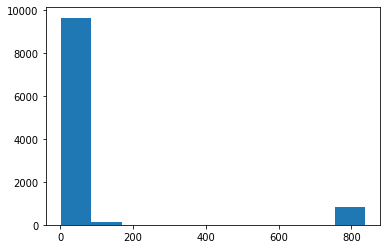

In [66]:
plt.hist(neighbors_count);

### Article with the most neighbor

In [67]:
pop_node = article_df.iloc[np.argmax(neighbors_count)]
pop_node.text

"Police arrest man armed with assault weapon, thwart 'possible ambush' ### A 24-year-old Grand Rapids-area man is in the Ottawa County Jail on a $45,000 bond after police responding to a crash last week found him passed out in the grass with a loaded assault weapon pointed toward the highway. ### Drugs, ammunition and a bulletproof vest were found in his vehicle, according to court records. ### Despite all that,\xa0Capt. Mark Bennett of the\xa0Ottawa County Sheriff’s Office said the man claims he was not lying in wait for the police. ### “He denies any threat to police and was charged with multiple crimes,” Bennett said. ### Joshua Michael Gryzen of Wyoming was arraigned July 13 in Ottawa County District Court on charges of drunken driving, resisting police, possession of firearms while under the influence of drugs or alcohol, possession of marijuana, and possession of a controlled substance.\xa0Gryzen demanded a preliminary examination and a probable-cause conference, which were sched

## Build Graph

In [68]:
def create_graph(neighbors):
    G = nx.Graph()
    G.add_nodes_from(list(range(len(neighbors))))

    for node in range(len(neighbors)):
        neighbor = neighbors[node]
        for n in neighbor:
            G.add_edge(node, n)
    return G

In [69]:
G = create_graph(neighbors)

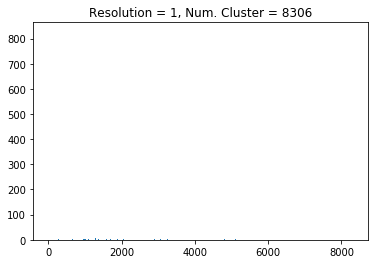

In [70]:
partitions = []
resolutions = [1] #, .99, .999, .9995, .9999]
for resolution in resolutions:
    partition = community.best_partition(G, resolution=resolution)
    partitions.append(partition)
    num_cluster = max([v for k,v in partition.items()]) + 1
    clusters = defaultdict(list)
    for k, v in partition.items():
        clusters[v].append(k)

    cluster_sizes = []
    for i, cluster in clusters.items():
        cluster_sizes.append(len(cluster))
    plt.bar(list(range(len(cluster_sizes))), cluster_sizes)
    plt.title(f'Resolution = {resolution}, Num. Cluster = {num_cluster}')
    plt.show()

In [71]:
np.argmax(cluster_sizes), np.max(cluster_sizes), np.median(cluster_sizes)

(28, 823, 1.0)

In [72]:
def plot_cluster_sizes(cluster):
    cluster_sizes = []
    for i, c in cluster.items():
        cluster_sizes.append(len(c))
    plt.title(f'Num cluster = {len(cluster.keys())}')
    plt.hist(cluster_sizes)
    plt.show()
    
def prune_cluster(cluster: dict, threshold) -> dict:
    pc = {}
    for key, value in clusters.items():
        if len(value) > threshold:
            pc[key] = value
    return pc

In [77]:
pc = prune_cluster(cluster, 5)

In [78]:
article_cluster = list(map(lambda d: clean_df.iloc[d[1]], pc.items()))
len(article_cluster)

56

In [79]:
len(article_cluster[0].title.tolist())

22

In [80]:
pc.keys()

dict_keys([23, 28, 34, 59, 70, 82, 103, 153, 201, 215, 241, 258, 294, 300, 316, 325, 354, 379, 382, 488, 501, 511, 686, 719, 739, 745, 756, 759, 765, 780, 798, 918, 920, 936, 989, 1120, 1130, 1134, 1166, 1196, 1257, 1272, 1288, 1423, 1437, 1474, 1568, 1801, 2203, 2223, 2514, 3045, 3216, 3239, 3563, 4004])

In [83]:
n = len(pc.keys())
sample_cluster = np.random.randint(n)
print('-'*50, 'title', '-'*50)
print('\n'.join(article_cluster[sample_cluster].title.tolist()))
print('-'*50, 'text', '-'*50)
print('\n'.join(list(map(lambda x: x[:100], article_cluster[sample_cluster].text.tolist()))))

-------------------------------------------------- title --------------------------------------------------
Video emerges of Macron bodyguard beating protester in Pari
WATCH: Michael Duffy scores astounding volley for Dundalk against Levadia Tallinn - Worldnews.com
All-female sailing team makes history, wins Race to Alaska - Worldnews.com
Shania Twain: Biography
Scott Rolen joins Jeff Mercer's staff with Indiana Hoosiers
Beaumont LGBTQ 2
US Labor chief visiting Boeing’s South Carolina facilities | The Tribune
IRS Drops Rule That Required Disclosure of Donors to Political Nonprofits
Upland planning big brewery, restaurant project in heart of Fountain Square | 2018-07-19
Best Gear VR apps and games - NewsOn6.com - Tulsa, OK - News, Weather, Video and Sports - KOTV.com |
NY officials: No major public health threat from steam blast | KSL.com
-------------------------------------------------- text --------------------------------------------------
Video emerges of Macron bodyguard beating p

## Top clusters

In [91]:
cluster_sizes = np.array(list(map(len, article_cluster)))

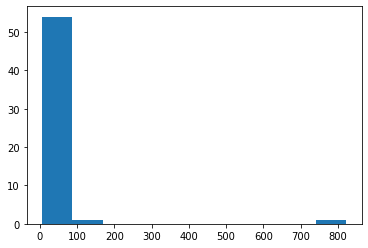

In [92]:
plt.hist(cluster_sizes);

In [97]:
index_by_size = list(reversed(np.argsort(cluster_sizes)))
cluster_sizes[index_by_size]

array([823, 150,  61,  55,  36,  22,  22,  22,  19,  19,  16,  15,  14,
        12,  11,  11,  11,  10,  10,  10,  10,   9,   9,   9,   8,   8,
         8,   8,   8,   7,   7,   7,   7,   7,   7,   7,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6])

In [105]:
top_cluster = article_cluster[index_by_size[0]]
top_cluster.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
29,290,zerohedge.com/news/2018-07-19/white-house-aske...,7/20/2018 1:35:15 AM -04:00,"Asked 8 Times For Trump-Rouhani Meeting, Iran ...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,63,2701,3.0
45,290,zerohedge.com/news/2018-07-19/meat-dairy-indus...,7/19/2018 2:46:05 PM -04:00,"Meat, Dairy Industry Surpass Big Oil As World'...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,78,2668,NaN
47,290,zerohedge.com/news/2018-07-19/us-cannot-afford...,7/19/2018 10:08:07 AM -04:00,The US CANNOT Afford the US Dollar at These Le...,The US CANNOT Afford the US Dollar at These Le...,1,en,76,3213,NaN
54,290,zerohedge.com/news/2018-07-19/bonds-bid-stocks...,7/19/2018 4:28:52 PM -04:00,"Bonds Bid, Stocks Skid, & Trump Dumps The Doll...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,61,1413,NaN
55,290,zerohedge.com/news/2018-07-17/fentanyl-related...,7/19/2018 11:15:27 PM -04:00,Fentanyl-Related Deaths Double In Six Months; ...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,93,4142,NaN


In [106]:
top_cluster.label.unique()

array([ 3., nan])

In [107]:
top_cluster[~top_cluster.label.isna()]

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
29,290,zerohedge.com/news/2018-07-19/white-house-aske...,7/20/2018 1:35:15 AM -04:00,"Asked 8 Times For Trump-Rouhani Meeting, Iran ...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,63,2701,3.0


In [110]:
cluster_center = emb_df.loc[top_cluster.index].mean()

In [112]:
from sklearn.neighbors import NearestNeighbors

In [113]:
nn = NearestNeighbors(n_neighbors=10)
nn.fit(emb_df.loc[top_cluster.index])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [114]:
dists, indices = nn.kneighbors([cluster_center])

In [115]:
dists

array([[0.62231777, 0.62685984, 0.63579323, 0.65572779, 0.66218848,
        0.66604384, 0.68373973, 0.69116017, 0.69363786, 0.69847444]])

In [120]:
top_cluster.iloc[indices[0]].title.tolist()

['Airbus Beluga XL Whale Takes Flight for the First Time  - NECN',
 'Malaysia launches crackdown on Isis after threats to kill the king and prime',
 'Poland Central School',
 'State of NFL entering training',
 'Bonds Bid, Stocks Skid, & Trump Dumps The Dollar | Zero Hedge',
 'Glenforest',
 'Aspall',
 'Toots & The Maytals',
 "In recorded staff meeting, Mark D'Antonio argues against union",
 'New Mexico to explore reuse of oil and gas wastewater | Tri-City Herald']